In [5]:
!pip install -qqU fastbook tornado==5.1 

     |████████████████████████████████| 516 kB 33.5 MB/s 
     |████████████████████████████████| 130 kB 57.1 MB/s 
     |████████████████████████████████| 130 kB 44.8 MB/s 


In [6]:
!pip install -q fastbook

import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [7]:
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in Lab2
- `Resize(640)` as item transform
- A size of 420 in the batch transforms
- Use a batch size of 32
- Use `set_seed()` to obtain reproducible results.
- Augmentations you find useful (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [8]:
path = Path('/content/gdrive/MyDrive/Colab Notebooks/digits')

digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files, 
                 splitter = set_seed(42),
                 get_y = parent_label,
                 item_tfms = Resize(640, 'squish'),
                 batch_tfms = aug_transforms(size=420, max_rotate = 90, max_zoom = 0.25, pad_mode= 'border'))
dls = digits.dataloaders(path, bs = 32)


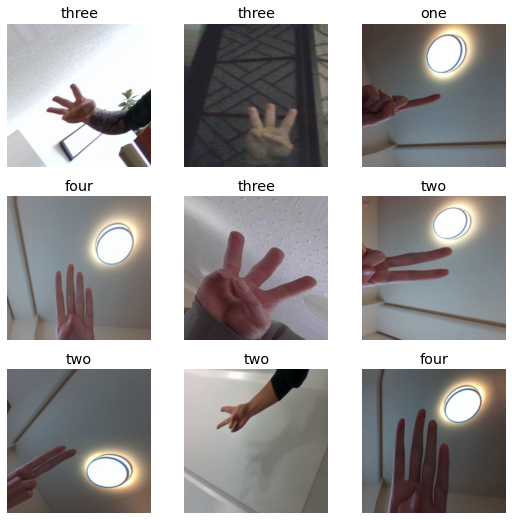

In [10]:
dls.train.show_batch(nrows=3, ncols=3)

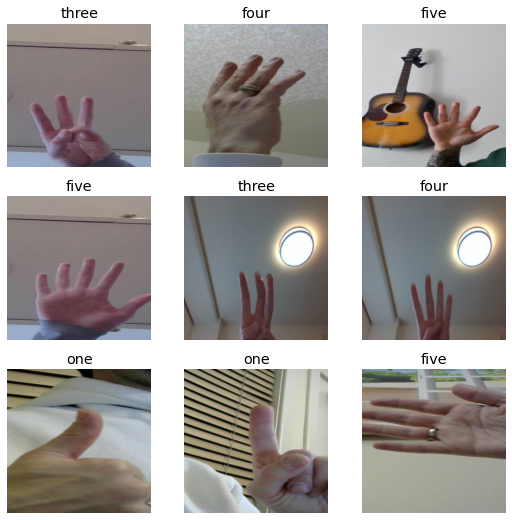

In [11]:
dls.valid.show_batch(nrows=3, ncols=3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

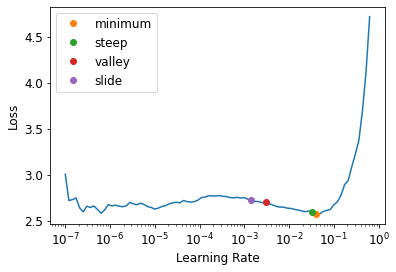

In [12]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [13]:
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

Minimum/10:	3.98e-03
Steepest point:	3.31e-02
Longest valley:	3.02e-03
Slide interval:	1.45e-03


In [14]:
learn.fine_tune(1, base_lr=0.1) # see how it would be out of box

epoch,train_loss,valid_loss,accuracy,time
0,3.427698,5.129343,0.410256,01:42


epoch,train_loss,valid_loss,accuracy,time
0,3.835202,2.993820,0.373626,00:28


In [20]:
learn.fine_tune(1, base_lr=9e-4) # see if it improves with new lr
# accuracy does better than lr of 0.1
# 3e-3 = 51
# 7e-3 = 54
# 1e-4 = 59
# 2e-4 = 61
# 4e-4 = 63
# 9e-4 = 67

epoch,train_loss,valid_loss,accuracy,time
0,1.533742,0.866408,0.644689,00:23


epoch,train_loss,valid_loss,accuracy,time
0,1.466862,0.816118,0.666667,00:28


In [21]:
# transfer learning
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 9e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.438997,1.551812,0.417582,00:23
1,2.115993,1.296860,0.538462,00:23


SuggestedLRs(valley=0.0002290867705596611)

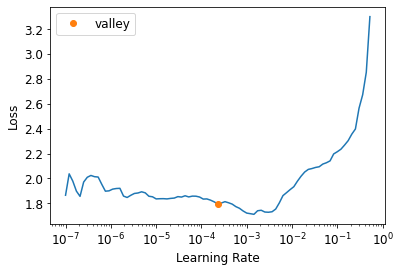

In [22]:
# unfreeze network and find learning rate again with different landscape
learn.unfreeze()
learn.lr_find()

In [29]:
learn.fit_one_cycle(4, lr_max=7e-4)
# performance improves

epoch,train_loss,valid_loss,accuracy,time
0,1.793303,1.607815,0.263736,00:27
1,1.780636,1.606732,0.201465,00:27
2,1.784401,1.614559,0.296703,00:27
3,1.776716,1.660880,0.300366,00:27


In [30]:
# discrimnative learning rates
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 9e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(9e-5,9e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.460188,1.613112,0.388278,00:22
1,2.129163,1.391571,0.468864,00:22


epoch,train_loss,valid_loss,accuracy,time
0,1.841419,1.182321,0.622711,00:27
1,1.582989,1.555249,0.652015,00:27
2,1.338361,1.049912,0.681319,00:27
3,1.156260,0.717242,0.750916,00:27
4,0.976150,0.527802,0.772894,00:27
5,0.774019,0.503409,0.802198,00:27
6,0.669377,0.734727,0.802198,00:27
7,0.569526,0.451901,0.838828,00:27
8,0.463967,0.340018,0.871795,00:27
9,0.339342,0.227499,0.915751,00:27


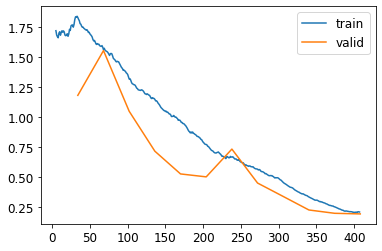

In [31]:
learn.recorder.plot_loss() # weird jump in validation loss but accuracy still gets better

## 2.2 Experiment with different batch sizes
Using the pipeline, number of epochs, learning rates from above, re-run the pipeline with a batch size of 16, 64

In [32]:
# batch size of 16
dls = digits.dataloaders(path, bs = 16)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 9e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(9e-5,9e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.529274,1.636911,0.432234,00:23
1,2.034333,1.427137,0.391941,00:23


epoch,train_loss,valid_loss,accuracy,time
0,1.749584,1.562886,0.520147,00:28
1,1.631864,1.419850,0.597070,00:27
2,1.604330,1.237267,0.567766,00:28
3,1.453009,0.759118,0.725275,00:28
4,1.259045,0.840220,0.721612,00:28
5,1.066874,0.879673,0.695971,00:28
6,0.846059,0.522623,0.820513,00:28
7,0.655778,0.396416,0.853480,00:28
8,0.579861,0.352637,0.853480,00:28
9,0.380995,0.226660,0.923077,00:28


In [33]:
# batch size of 64
dls = digits.dataloaders(path, bs = 64)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 9e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(9e-5,9e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.482349,1.545220,0.340659,00:23
1,2.238337,1.452370,0.443223,00:24


epoch,train_loss,valid_loss,accuracy,time
0,1.873727,1.071363,0.593407,00:28
1,1.519688,1.849404,0.571429,00:28
2,1.271945,2.370731,0.615385,00:28
3,1.096177,1.309479,0.648352,00:28
4,0.941684,0.559128,0.805861,00:28
5,0.780431,0.727745,0.769231,00:28
6,0.663245,1.138837,0.721612,00:28
7,0.551038,0.442897,0.857143,00:29
8,0.461455,0.352322,0.886447,00:28
9,0.379064,0.217161,0.923077,00:28


In [34]:

dls = digits.dataloaders(path, bs = 16)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 9e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(9e-5,9e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.390738,1.411113,0.410256,00:23
1,2.033077,1.079726,0.600733,00:24


epoch,train_loss,valid_loss,accuracy,time
0,1.668266,1.068303,0.663004,00:28
1,1.624565,1.400665,0.593407,00:27
2,1.569591,1.529448,0.593407,00:28
3,1.520339,1.305333,0.582418,00:28
4,1.301795,0.830375,0.717949,00:28
5,1.039533,0.638093,0.783883,00:28
6,0.840650,0.840782,0.699634,00:28
7,0.694629,0.539856,0.783883,00:28
8,0.564522,0.332038,0.860806,00:28
9,0.402890,0.196978,0.919414,00:28


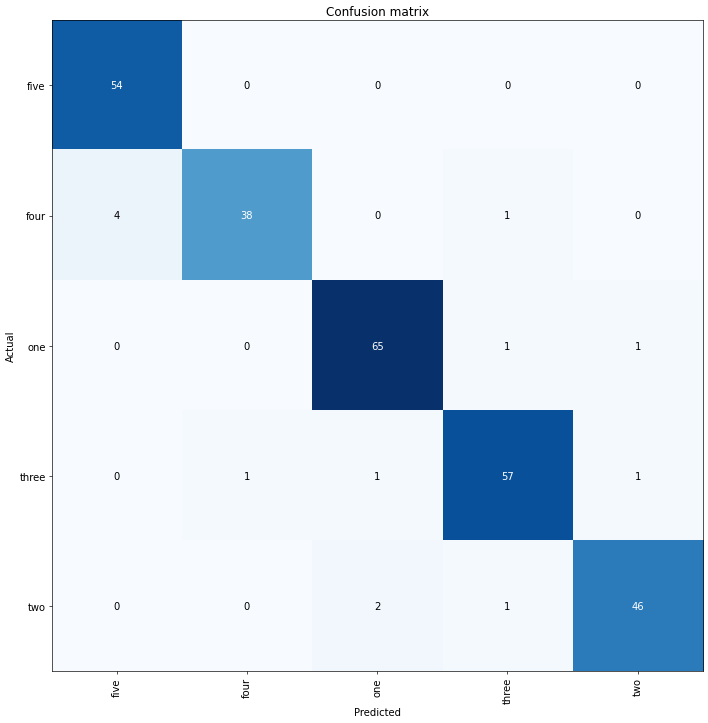

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [36]:
interp.most_confused(min_val=1)

[('four', 'five', 4),
 ('two', 'one', 2),
 ('four', 'three', 1),
 ('one', 'three', 1),
 ('one', 'two', 1),
 ('three', 'four', 1),
 ('three', 'one', 1),
 ('three', 'two', 1),
 ('two', 'three', 1)]

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [37]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks')

if not (export_path/'models').exists():
  (export_path/'models').mkdir()

In [38]:
learn.export(fname=(export_path/"models/digits_modelNEW.pkl"))
(export_path/"models").ls()

(#2) [Path('/content/gdrive/MyDrive/Colab Notebooks/models/digits_model.pkl'),Path('/content/gdrive/MyDrive/Colab Notebooks/models/digits_modelNEW.pkl')]